In [1]:
import matplotlib.pyplot as plt

import lightdde as dde
from essential import *
from qmodels import *
from torchsummary import summary

In [2]:
qnet = NetMulAdd(in_dim=2, out_dim=3)
cnet = ClassicNet(in_dim=2, out_dim=3, hidden_dim=16)

In [3]:
summary(qnet, input_size=(1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        TorchLayer-1                    [-1, 2]               0
            Linear-2                    [-1, 1]               3
           QScalar-3                    [-1, 1]               0
            Linear-4                   [-1, 10]              30
              ReLU-5                   [-1, 10]               0
            Linear-6                   [-1, 10]             110
              ReLU-7                   [-1, 10]               0
            Linear-8                    [-1, 1]              11
           CScalar-9                    [-1, 1]               0
       TorchLayer-10                    [-1, 2]               0
           Linear-11                    [-1, 1]               3
          QScalar-12                    [-1, 1]               0
           Linear-13                   [-1, 10]              30
             ReLU-14                   

In [4]:
summary(cnet, input_size=(1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]              48
              ReLU-2                   [-1, 16]               0
            Linear-3                   [-1, 16]             272
              ReLU-4                   [-1, 16]               0
            Linear-5                    [-1, 1]              17
           CScalar-6                    [-1, 1]               0
            Linear-7                   [-1, 16]              48
              ReLU-8                   [-1, 16]               0
            Linear-9                   [-1, 16]             272
             ReLU-10                   [-1, 16]               0
           Linear-11                    [-1, 1]              17
          CScalar-12                    [-1, 1]               0
           Linear-13                   [-1, 16]              48
             ReLU-14                   

# Inference

In [5]:
data = dde.data.PDEData(
    domain=domain,
    pde=pde,
    bcs=[boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    exact_solution=[u_func, v_func, p_func],
    num_domain=2601,
    num_bc=400,
    num_test=4000,
)

## classic model

In [7]:
net = ClassicNet(in_dim=2, out_dim=3, hidden_dim=16)

model = dde.Model(
    data=data,
    model=net,
    save_path="models/classic_1000e_new",
    log_every=10,
    save_every=100,
)

model.compile()

Loaded snapshot at epoch 1000


## quantum model

In [6]:
net = NetMulAdd(in_dim=2, out_dim=3)

model = dde.Model(
    data=data,
    model=net,
    save_path="models/big_qmodel",
    log_every=10,
    save_every=100,
)

model.compile()

Loaded snapshot at epoch 100


Executed in 44.93 sec.


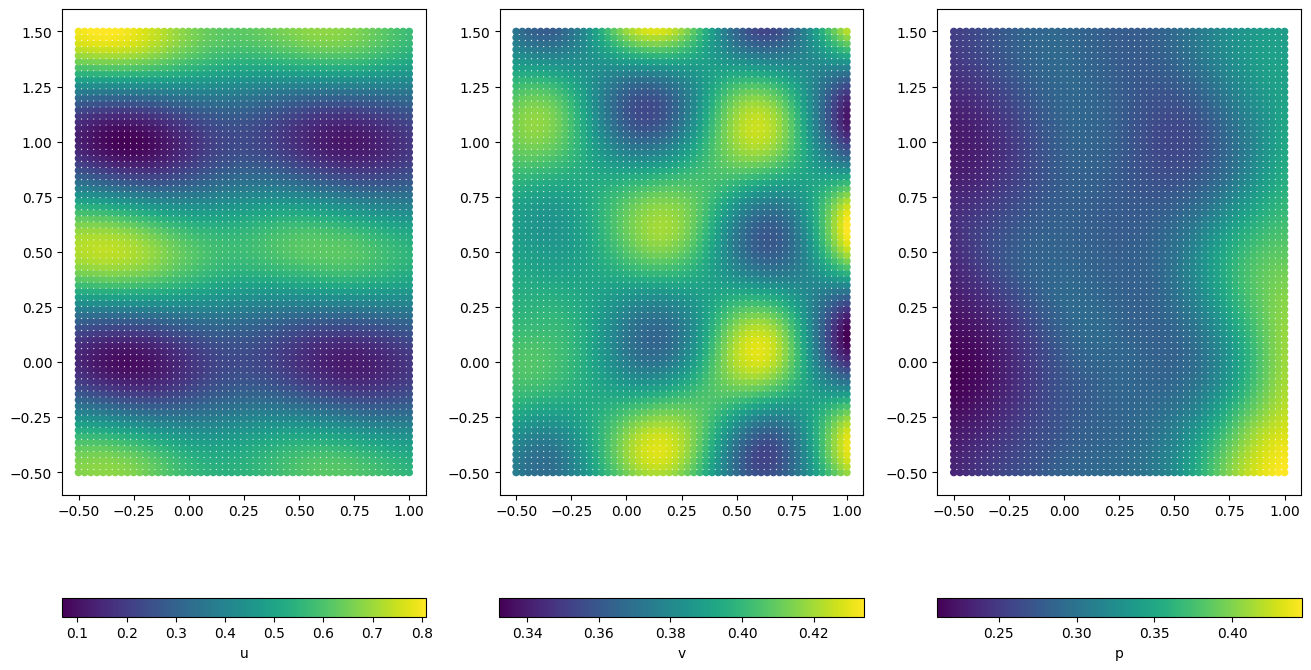

''

In [7]:
dde.scatter_plot(model, s=20)
;

# Load csv loss

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df_q = pd.read_csv("models/big_qmodel/log.csv", index_col="epoch")
df_c = pd.read_csv("models/classic_1000e_new/log.csv", index_col="epoch")

In [10]:
df_q.head()

,loss_train,u_err,v_err,p_err
epoch,,,,
10,3.039752,1.393521,0.574457,1.172471
20,2.884202,1.382118,0.568061,1.170586
30,2.762737,1.370475,0.564166,1.170808
40,2.664394,1.357467,0.561409,1.172931
50,2.580643,1.342522,0.557962,1.175710


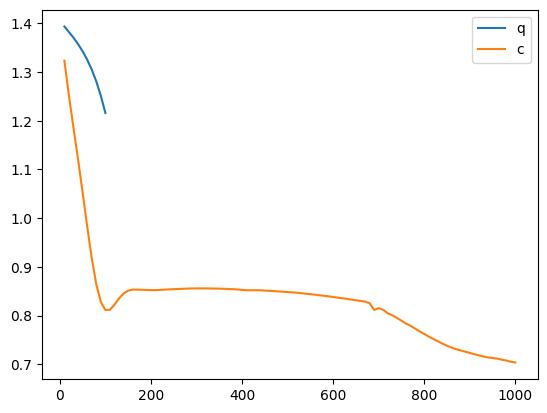

In [12]:
plt.plot(df_q.index, df_q["u_err"], label="q")
plt.plot(df_c.index, df_c["u_err"], label="c")
plt.legend()
plt.show()